# Importing Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from torch.autograd import Variable

# Reading and Transforming Data

In [2]:
cols=['category','message']
data= pd.read_csv("/content/SMSSpamCollection.tsv", delimiter='\t', names=cols)
data.head()

,category,message
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


Let's do some transformations!

In [3]:
data['category']=data['category'].map({'ham':0,'spam':1})
data.head()

,category,message
0,0,I've been searching for the right words to tha...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,"Nah I don't think he goes to usf, he lives aro..."
3,0,Even my brother is not like to speak with me. ...
4,0,I HAVE A DATE ON SUNDAY WITH WILL!!


In [4]:
# Making arrays for labels and features

features=data.message.values
labels=data.category.values
print(features.shape)
print(labels.shape)

(5568,)
(5568,)


In [5]:
t = Tokenizer(num_words=1000)
t.fit_on_texts(features)
features = t.texts_to_matrix(features, mode='tfidf')

In [6]:
features.shape

(5568, 1000)

# Building Model

In [7]:
class Model(nn.Module):
  def __init__(self,input,hidden,output):
    super(Model,self).__init__()
    self.l1=nn.Linear(input,hidden)
    self.l2=nn.Linear(hidden,hidden)
    self.l3=nn.Linear(hidden,output)

  def forward(self,x):
    x = self.l1(x)
    out= F.relu(x)
    out=F.relu(self.l2(out))
    out=self.l3(out)
    return out


In [8]:
INPUT=1000
HIDDEN=100
OUTPUT=2
model=Model(INPUT,HIDDEN,OUTPUT)

In [9]:
# Calculaitng Params 
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #(1000*100+100)+(100*100+10)+(100*2+2)=110,402
print(pytorch_total_params)

110402


In [10]:
# Let's do train/test split
X_train,X_test, y_train,y_test=train_test_split(features,labels,shuffle=True)

In [11]:
# Let's define our loss function and optimization technique
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and Testing Model
Using:
1. Using batch gradient descent
2. Corssentropy loss function
3. Adam optimizer

In [12]:
# let's use batch gradient descent for training our model that we created above! (if epochs=10 then 10 exposures to entire training data for learning)
def train(epochs,lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    x_train = Variable(torch.from_numpy(X_train)).float()
    y_train_ = Variable(torch.from_numpy(y_train)).long()
    x_test = Variable(torch.from_numpy(X_test)).float()
    y_test_ = Variable(torch.from_numpy(y_test)).long()
    train_losses=[]
    test_losses=[]
    model.train() # Each iteration of for loop updates our model's parameters through backpropagation
    for epoch in range(epochs):
        optimizer.zero_grad() 
        #let's forward pass and calculate train_loss
        y_pred_train = model(x_train)
        train_loss = loss(y_pred_train, y_train_)
      
        # Let's register train losses for each epoch by appending relevant list
        train_losses.append(train_loss.item())
        
        # Let's print train_loss and test_loss for each epoch
        #print ("epoch #",epoch+1)
        #print ("train_loss: ", train_loss.item())
        
        # Let's compute correct train and test predictions
        pred_train = torch.max(y_pred_train, 1)[1].eq(y_train_).sum()######smokeeeeeeeeeeeeeeeeeees!(Expanded below)
        # Let's print train accuracies
        # print ("train acc:(%) ", (100*pred_train/len(x_train)))
        
        train_loss.backward()
        optimizer.step()
        #Let's implement model on test set to figure out test loss for each epoch 
        #Note the position of this step after the model has taken one step towards improvement
        y_pred_test = model(x_test)
        test_loss = loss(y_pred_test, y_test_)
        test_losses.append(test_loss.item())
    return (y_pred_train, train_losses, test_losses,model)

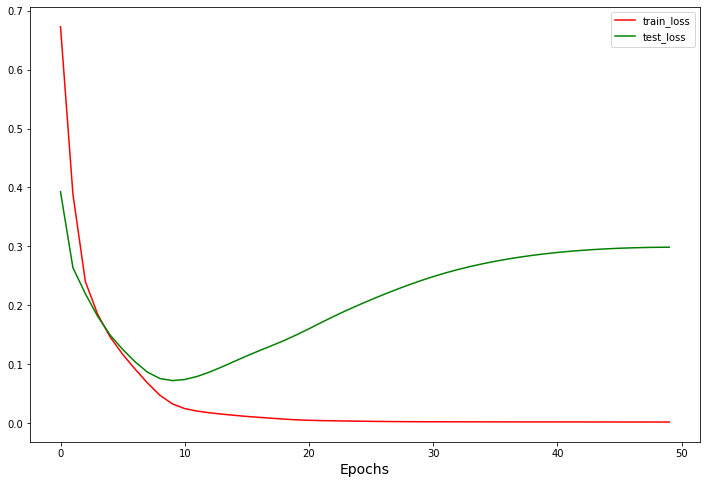

In [13]:
y_p_t,train_l,test_l,model=train(50)
plt.figure(figsize=(12,8))
plt.plot(train_l,label='train_loss',color='red')
plt.plot(test_l,label='test_loss',color='green')
plt.legend()
plt.xlabel('Epochs',size=14)
plt.show()

**The graph above shows that:**
1. Loss is minimum for both train and test set at around 10th epoch
2. After 10th epoch the model starts to get too greedy and further improves training performace
3. Nonetheless,model that turns greedy after 10th epoch fails to generalize on test set beyond 10th epoch**

# Classification Report

In [14]:
from sklearn.metrics import classification_report
x_test = Variable(torch.from_numpy(X_test)).float()
y_hat= torch.max(model(x_test),1)[1]
y_hat=y_hat.data.numpy()
cr= classification_report(y_test,y_hat,target_names=['ham','spam'])
print('Test Set Calssification Report:\n',cr)


Test Set Calssification Report:
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1206
        spam       0.88      0.93      0.90       186

    accuracy                           0.97      1392
   macro avg       0.93      0.96      0.94      1392
weighted avg       0.97      0.97      0.97      1392



1. Precision/PPV = TP/TP+FP ( ability of a classifier not to label an instance positive that is actually negative)
2. Recall/NPV = TP/(TP+FN) (ability of a classifier to not label an instance negative that is actually positive)
3. F1 Score = 2*(Recall * Precision) / (Recall + Precision) 

F1 score is a weighted harmonic mean of precision and recall! Has both PPV and NPV. So, a better measure than accuray!

![picture](https://drive.google.com/uc?id=1ansfjcYZNie0x8bPSkzF8yuLmY666fH3)